In [34]:
import pandas as pd
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt 

%matplotlib inline

### Lets use fetch_20newsgroups to load the data - let's chose two categories per the [sklearn userguide](https://scikit-learn.org/stable/datasets/index.html#newsgroups-dataset)

In [35]:
### code 
cats = ['soc.religion.christian', 'talk.religion.misc']

## get documents from the appropriate categories 
ng = fetch_20newsgroups(categories=cats)

## I like having the target column be a string value in many cases 
y_str = [ng.target_names[0] if i ==0 else ng.target_names[1] for i in ng.target]

df = pd.DataFrame({'Text':ng.data, 'Target':y_str})

df.head()

,Text,Target
0,From: rsteele@adam.ll.mit.edu (Rob Steele)\nSu...,soc.religion.christian
1,"Subject: Re: After 2000 years, can we say that...",talk.religion.misc
2,From: max@hilbert.cyprs.rain.com (Max Webb)\nS...,soc.religion.christian
3,From: weinss@rs6101.ecs.rpi.edu (Stephen Andre...,talk.religion.misc
4,From: emarsh@hernes-sun.Eng.Sun.COM (Eric Mars...,talk.religion.misc


### Train test split our data - then instantiate a countvectorizer object and look for potential stopwords

In [36]:
## Instatiate a countvectorizer object - fit transform and then put the results in a dataframe 
X_train, X_test, y_train, y_test = train_test_split(df['Text'], \
                                                   df['Target'], \
                                                   random_state=93510)
cvec = CountVectorizer(min_df=3) # shuffles around indices and loses order

X_train_cvec = cvec.fit_transform(X_train)

In [37]:
X_train_cvec

<732x6289 sparse matrix of type '<class 'numpy.int64'>'
	with 123373 stored elements in Compressed Sparse Row format>

In [38]:
# .getfeaturenames creates columns here, .todense makes the sparse matrix a matrix that can be dataframed
X_train_df = pd.DataFrame(X_train_cvec.todense(), columns = cvec.get_feature_names())
X_train_df.loc[730, :'jesus']

00            1
000           0
0001          0
01            1
01580         0
             ..
jennifer      0
jerry         0
jersey        0
jerusalem     0
jesus        11
Name: 730, Length: 3116, dtype: int64

### How can we build a plot displaying the most frequently occuring words? 

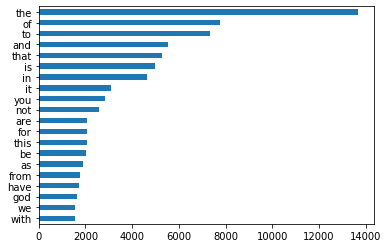

In [39]:
X_train_df.sum().sort_values().tail(20).plot.barh(); # before removing stop words

### Add stopwords to our vectorizer - any other parameters we could tune?

In [63]:
# Stop words
stops = list(ENGLISH_STOP_WORDS)

In [47]:
X_train, X_test, y_train, y_test = train_test_split(df['Text'], \
                                                   df['Target'], \
                                                   random_state=13326)
cvec = CountVectorizer(min_df=3, stop_words=stops)
X_train_cvec = cvec.fit_transform(X_train)
X_train_df = pd.DataFrame(X_train_cvec.todense(), columns = cvec.get_feature_names())

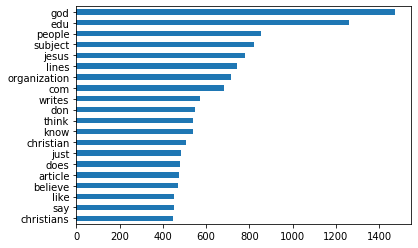

In [45]:
X_train_df.sum().sort_values().tail(20).plot.barh(); # before removing stop words

### Let's run a Logistic Regression and look at a confusion matrix of our results 

In [48]:
lr = LogisticRegression()

X_test_cvec = cvec.transform(X_test)

X_test_df = pd.DataFrame(X_test_cvec.todense(), \
                         columns = cvec.get_feature_names())

lr.fit(X_train_df, y_train)

lr.score(X_test_df, y_test)

/opt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.9754098360655737

In [49]:
preds = lr.predict(X_test_df) # Must store predictions so we can use it in confusion matrix

In [58]:
cols = 'Preds: ' + lr.classes_

rows = 'Actual ' + lr.classes_ 
pd.DataFrame(confusion_matrix(y_test, preds), columns=cols, index=rows) # using predictions vs y_test for our confusion matrix

,Preds: soc.religion.christian,Preds: talk.religion.misc
Actual soc.religion.christian,153,2
Actual talk.religion.misc,4,85


### Analyze the coefs of our Logistic Regression 

In [61]:
lr.classes_

array(['soc.religion.christian', 'talk.religion.misc'], dtype=object)

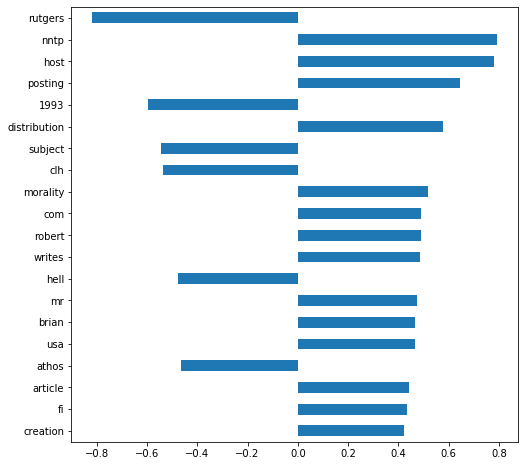

In [62]:
fig , ax = plt.subplots(figsize=(8,8))
coef_df = pd.DataFrame(lr.coef_, columns=cv.get_feature_names()).T
coef_df['ABS'] = coef_df[0].abs()
coef_df.sort_values('ABS').tail(20).loc[:,0].plot.barh(ax=ax);
#rutgers is .8 to the e (44%) as liklely to be included in soc.religion.christian, in this current form